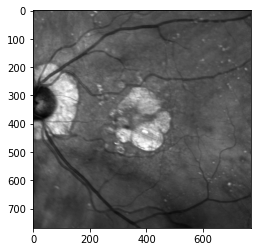

In [8]:
from pathlib import Path
import matplotlib.pyplot as plt

# Define the path to the directory containing the fundus images
fundus_dir = Path("../data/156518")

# Filter the files in the directory to only include PNG files
fundus_images = [x for x in fundus_dir.iterdir() if x.is_file() and x.suffix == ".png"]
fundus_images = [x for x in fundus_images if "_L.png" in x.name]

# Get the first fundus image
first_image = fundus_images[0]

# Load the first image using Matplotlib's imread function
image = plt.imread(first_image)

# Display the first image
plt.imshow(image, cmap='gray')
plt.show()

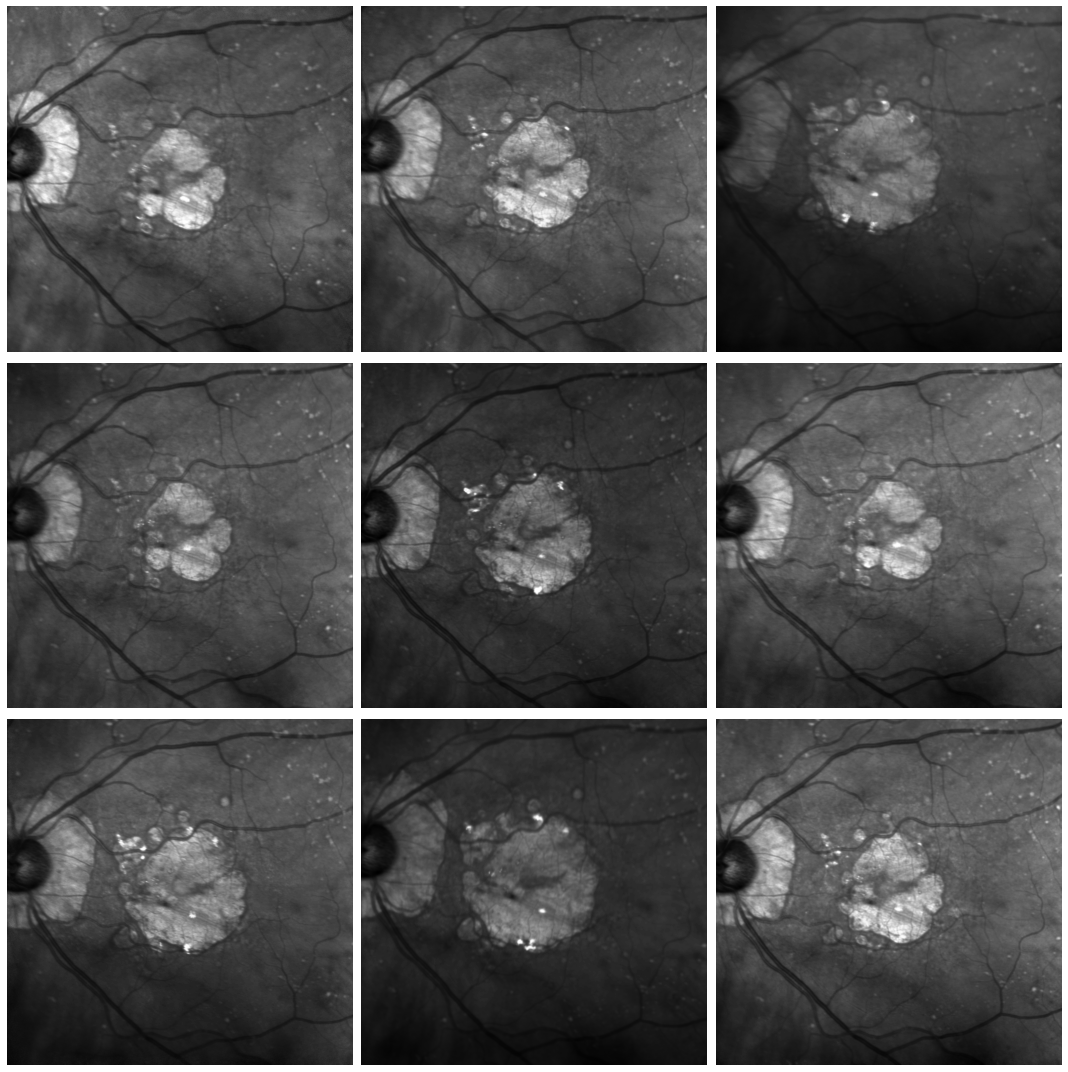

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of rows and columns for the subplots
nrows, ncols = 3, 3

# Create the subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15))
axs = axs.ravel()

# Load and display the first 9 images
for i in range(9):
    image = plt.imread(fundus_images[i])
    axs[i].imshow(image, cmap='gray')
    axs[i].axis("off")

plt.tight_layout()
plt.show()

In [54]:
import os
import cv2
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
from skimage.registration import optical_flow_tvl1, optical_flow_ilk
from skimage.transform import warp
from skimage.color import rgb2gray

# Set the root directory for the patient data
root_dir = Path('../data/156518')

# Get the list of image filenames for the left eye
image_filenames = [f for f in os.listdir(root_dir) if 'L.png' in f]

# Read the images into a list
images = [cv2.imread(str(root_dir / f)) for f in image_filenames]

# Convert the images to grayscale
gray_images = [rgb2gray(img) for img in images]

# Register all images to the first image
template = gray_images[0]

# Remove invalid images
final_images = [x for x in gray_images[1:] if x.shape == template.shape]

# Do the registration process
registered_images = []
for i, img in enumerate(tqdm(final_images)):

        # calculate the vector field for optical flow
        v, u = optical_flow_tvl1(template, img)
        # use the estimated optical flow for registration
        nr, nc = template.shape
        row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                             indexing='ij')
        registered = warp(img, np.array([row_coords + v, col_coords + u]), mode='edge')
        #registered = cv2.warpAffine(img, flow, (img.shape[1], img.shape[0]))
        registered_images.append(registered)

  0%|          | 0/101 [00:00<?, ?it/s]

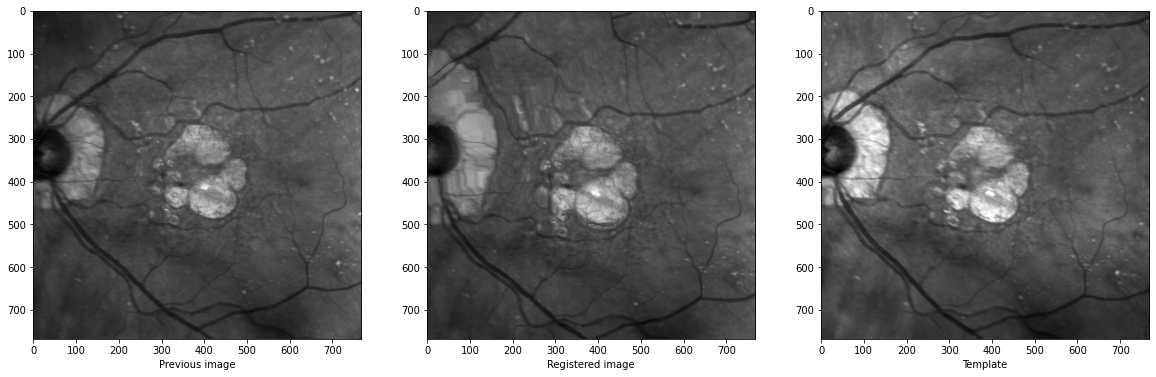

In [128]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs = axs.ravel()

i = 2
axs[0].imshow(final_images[i], cmap='gray')
axs[0].set_xlabel("Previous image")
axs[1].imshow(registered_images[i], cmap='gray')
axs[1].set_xlabel("Registered image")
axs[2].imshow(template, cmap='gray')
axs[2].set_xlabel("Template")

plt.show()

In [62]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_root_mse as nrmse

def evaluate_registration(template_img, registered_imgs):
    l1_losses = []
    ncc_values = []
    ssim_values = []
    
    for registered_img in registered_imgs:
        l1_loss = np.mean(np.abs(template_img - registered_img))
        l1_losses.append(l1_loss)
        
        ncc = np.corrcoef(template_img.ravel(), registered_img.ravel())[0,1]
        ncc_values.append(ncc)
        
        ssim_value = ssim(template_img, registered_img, data_range=registered_img.max() - registered_img.min())
        ssim_values.append(ssim_value)
        
    return l1_losses, ncc_values, ssim_values


l1_losses, ncc_values, ssim_values = evaluate_registration(template, registered_images)

print("L1 losses:", np.mean(l1_losses))
print("Normalized cross-correlation values:", np.mean(ncc_values))
print("Structural similarity index values:", np.mean(ssim_values))

L1 losses: 0.08169580604522776
Normalized cross-correlation values: 0.7297043703588232
Structural similarity index values: 0.6343061030028727


## General Python class

In [110]:
def retrieve_images(patient_id = '156518'):
    # Set the root directory for the patient data
    root_dir = Path(f'../data/{patient_id}')

    # Get the list of image filenames for the left eye
    image_filenames = [f for f in os.listdir(root_dir) if 'L.png' in f]

    # Read the images into a list
    images = [cv2.imread(str(root_dir / f)) for f in image_filenames]

    # Convert the images to grayscale
    gray_images = [rgb2gray(img) for img in images]

    # Register all images to the first image
    template = gray_images[0]

    # Remove invalid images
    final_images = [x for x in gray_images[1:] if x.shape == template.shape]

    return final_images, template

In [111]:
def optical_flow(template, img):
    # calculate the vector field for optical flow
    v, u = optical_flow_tvl1(template, img)
    # use the estimated optical flow for registration
    nr, nc = template.shape
    row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                         indexing='ij')
    registered = warp(img, np.array([row_coords + v, col_coords + u]), mode='edge')
    return registered

In [112]:
import wandb

class RegistrationAlgorithm:
    
    def __init__(self, registration_function):
        self.registration_function = registration_function
        self.final_images, self.template = retrieve_images()
        self.registered_images = self.apply_registration()
        
    def apply_registration(self):
        # Do the registration process
        registered_images = []
        for i, img in enumerate(tqdm(self.final_images)):
            registered = self.registration_function(self.template, img) 
            registered_images.append(registered)
        return registered_images
    
    def evaluate_registration(self):
        l1_losses = []
        ncc_values = []
        ssim_values = []

        for registered_img in self.registered_images:
            l1_loss = np.mean(np.abs(self.template - registered_img))
            l1_losses.append(l1_loss)

            ncc = np.corrcoef(self.template.ravel(), registered_img.ravel())[0,1]
            ncc_values.append(ncc)

            ssim_value = ssim(self.template, registered_img, data_range=registered_img.max() - registered_img.min())
            ssim_values.append(ssim_value)

        # wandb.init(project='macuject-registration', entity="charlieoneill")
        # wandb.log({"Model": self.registration_function.__name__, 
        #            "L1 loss": np.mean(l1_losses), 
        #            "NCC": np.mean(ncc_values), 
        #            "SSIM": np.mean(ssim_values)})
        return l1_losses, ncc_values, ssim_values


In [113]:
opt = RegistrationAlgorithm(optical_flow)

  0%|          | 0/101 [00:00<?, ?it/s]

In [114]:
l1_losses, ncc_values, ssim_values = opt.evaluate_registration()
print("L1 losses:", f"{np.mean(l1_losses):.2f}")
print("Normalized cross-correlation values:", f"{np.mean(ncc_values):.2f}")
print("Structural similarity index values:", f"{np.mean(ssim_values):.2f}")

L1 losses: 0.08
Normalized cross-correlation values: 0.73
Structural similarity index values: 0.63


## Spatial transformer network

In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
import numpy as np
import cv2
from skimage.color import rgb2gray
from pathlib import Path
import os

# Define the spatial transformer network
class SpatialTransformerNetwork(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, n_fcs, n_convs, n_affine_params, height, width):
        super(SpatialTransformerNetwork, self).__init__()
        self.height = height
        self.width = width

        # Define the localisation network
        self.localization = nn.Sequential(
            nn.Conv2d(n_input_channels, n_convs, kernel_size=7, stride=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(n_convs, n_convs, kernel_size=5, stride=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(n_convs, n_fcs, kernel_size=3, stride=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(n_fcs * height * width, n_affine_params),
            nn.ReLU(True),
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[0].weight.data.zero_()
        self.fc_loc[0].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

        # Define the grid generator
        self.grid_generator = F.affine_grid(height, width)

        # Define the sampler
        self.sampler = nn.Sequential(
            nn.Conv2d(n_input_channels, n_output_channels, kernel_size=7, stride=1),
            nn.ReLU(True),
        )

    # Spatial transformer network forward function
    def forward(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, self.height * self.width * 32)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = self.grid_generator(theta)
        x = self.sampler(x)
        return torch.nn.functional.grid_sample(x, grid)
    
# Initialize the model and optimizer
model = SpatialTransformerNetwork(n_input_channels=1, n_output_channels=1, n_fcs=3, n_convs=3, n_affine_params=6, height=768, width=768)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
for epoch in range(100):
    for i, (template, img) in enumerate(zip(templates, final_images)):
        optimizer.zero_grad()

        registered = model(img.unsqueeze(0).unsqueeze(0))
        loss = F.l1_loss(registered, template)
        loss.backward()
        optimizer.step()

/Users/charlesoneill/mambaforge/lib/python3.9/site-packages/torch/nn/functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


AttributeError: 'int' object has no attribute 'is_floating_point'

In [ ]:
# Test the model
with torch.no_grad():
    for i, (template, img) in enumerate(zip(templates, final_images)):
        registered = model(img.unsqueeze(0).unsqueeze(0))
        registered = registered.squeeze().numpy()
        template = template.numpy().squeeze()
        # Use the registered image and compare it with the template
        # You can add code here to display or save the registered image